# Pytorch Transfer Learning

What is transfer learning?

Transfer learning involves taking the parameters of what one model has learned on another dataset and applying to our own problem.

In [1]:
import torch
import torchvision

print(torch.__version__)
print(torchvision.__version__)

2.1.0+cu121
0.16.0+cu121


In [2]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4056, done.
remote: Counting objects: 100% (1234/1234), done.
remote: Compressing objects: 100% (110/110), done.
remote: Total 4056 (delta 1141), reused 1124 (delta 1124), pack-reused 2822
Receiving objects: 100% (4056/4056), 649.94 MiB | 16.15 MiB/s, done.
Resolving deltas: 100% (2386/2386), done.
Updating files: 100% (248/248), done.


In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## 1.0 Get data

We need our pizza, steak, sushi data to build a transfer learning model on.

In [4]:
import os
import zipfile

from pathlib import Path

import requests

def download_data(data_path: str, img_path_str:str, zipped_data:str, request_q:str):
    # Setup data path
    data_path = Path(data_path)
    image_path = data_path / img_path_str

    if image_path.is_dir():
        print(f"{image_path} directory exists, skipping re-download.")
    else:
        print(f"Did not find {image_path}, downloading it... ")
        image_path.mkdir(parents=True, exist_ok=True)

    # download pizza, steak, sushi data
    with open(data_path / zipped_data, "wb") as f:
        r = requests.get(request_q)
        print("Downloading pizza, steak, sushi data...")
        f.write(r.content)

    # unzip data
    with zipfile.ZipFile(data_path / zipped_data, "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...")
        zip_ref.extractall(image_path)

    # remove .zip file
    os.remove(data_path / zipped_data)

    # setup dir paths
    train_dir = image_path / 'train'
    test_dir = image_path / 'test'

    return image_path, train_dir, test_dir




In [5]:
img_path, train_dir, test_dir = download_data(data_path="data/", img_path_str="pizza_steak_sushi",
              zipped_data="pizza_steak_sushi.zip",
              request_q='https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip')


Did not find data/pizza_steak_sushi, downloading it... 
Unzipping pizza, steak, sushi data...


In [6]:
train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

## 2.0 Dataloaders

There are 2 ways to transform data:

1. Manually created transforms - you define what transforms you want your data to go through.
2. Automatically created transforms - the transforms for your data are defined by the model you'd like to use.

Important point: when using a pretrained model, it is important that the data(including your custom data) that you pass through it is transformed in the same way that the data the model was trained on.

### 2.1 Creating a transform for `torchvision.models` (manual creation)
`torchvision.models` contains pretrained models (models ready for transfer learning) right within `torchvision`.

> All pre-trained models expect input images normalized in the same way, i.e. mini-batches of 3-channel RGB images of shape (3 x H x W), where H and W are expected to be at least 224. The images have to be loaded in to a range of [0, 1] and then normalized using mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225]. You can use the following transform to normalize


In [7]:
from torchvision import transforms

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

manual_transforms = transforms.Compose([
                                        transforms.Resize(size=(224, 224)),
                                        transforms.ToTensor(), # get images into range [0, 1]
                                        normalize]) # make sure images have the same distribution (on rgb channels) as ImageNet (where our pretrained models have been trained)

In [8]:
from going_modular.going_modular import data_setup

train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=manual_transforms,
                                                                               batch_size=32,
                                                                               )
train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7cca07f469e0>,
 ['pizza', 'steak', 'sushi'])

### 2.2 Creating a transform for `torchvision.models` (auto creation)

Automatic data transform creation based on the pretrained model.

In [9]:
# get a set of pretrained model weights
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # "DEFAULT" = best available weights
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

In [10]:
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [11]:
# Create Dataloaders using automatic transforms
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=auto_transforms,
                                                                               batch_size=32,
                                                                               )
train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7cca07f45d50>,
 ['pizza', 'steak', 'sushi'])

## 3.0 Getting a pretrained model

There are various places to get a pretrained model, such as:
1. PyTorch domain libraries
2. Libraries like 'timm'(torch image models)
3. HuggingFace Hub (for plenty of different models)
4. Paperswithcode(for models across different spaces/domains)

### 3.1 Which pretrained model should you use?

*Experiment, experiment, exeriment!*

The whole idea of transfer learning: take an already well-performing modl from a problem space similar to your own and then customize your own problem.

Three  to consider:
1. Speed - how fast does it run?
2. Size - how big is the model?
3, Performance = how well does it go on your chosen problem(e.g how well does it classify food images? FoodVision Mini)?

Where does the model live?

Is it on device? (like a self-driving car)

Or does it live on a server?

Looking at https://pytorch.org/vision/main/models.html#table-of-all-available-classification-weights

Which model should we choose?

We are using EffNetB0 since it has the best performance to size(amount of parameters needed) ratio.

However, in light of The Bitter Lesson, if we had infinite compute, we'd likely pick the biggest model + most parameters + most generalwe could

### 3.2 Setting up a pretrained model

Want to create an instance of pretrained EffNetB0


In [12]:
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
from torchvision.models._api import WeightsEnum
from torch.hub import load_state_dict_from_url


def get_state_dict(self, *args, **kwargs):
    kwargs.pop("check_hash")
    return load_state_dict_from_url(self.url, *args, **kwargs)

WeightsEnum.get_state_dict = get_state_dict

weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
model = torchvision.models.efficientnet_b0(weights=weights)
model

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-3dd342df.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 24.5MB/s]


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [13]:
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

### 3.3 Getting a summary of our model with `torchinnfo.summary()`

In [14]:
# print with torchinfo
from torchinfo import summary

summary(model=model,
        input_size=(1, 3, 224, 224),
        col_names=['input_size', 'output_size', 'num_params', 'trainable'],
        col_width=20,
        row_settings=['var_names'])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 1000]            --                   True
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   True
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   True
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    864                  True
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    64                   True
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 16, 112,

### 3.4 Freezing the base model and changing the output layer to suit our needs

With a feature extractor model, typically you will "freeze" the base layers of a pretrained/foundation model and update the output layers to suit your own problem.

In [15]:
model.features
# model.avgpool

Sequential(
  (0): Conv2dNormActivation(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): SiLU(inplace=True)
  )
  (1): Sequential(
    (0): MBConv(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
          (activation): SiLU(inplace=True)
          (scale_activation): Sigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), 

In [16]:
# Freeze all of the base layers in EffNetB0
for param in model.features.parameters():
    param.requires_grad = False
    # print

In [17]:
summary(model=model,
        input_size=(1, 3, 224, 224),
        col_names=['input_size', 'output_size', 'num_params', 'trainable'],
        col_width=20,
        row_settings=['var_names'])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 1000]            --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

In [18]:
# update the classifier head of our model to suit our problem

torch.manual_seed(42)
torch.cuda.manual_seed(42)

model.classifier = nn.Sequential(
        nn.Dropout(p=0.2, inplace=True),
        nn.Linear(in_features=1280, # feature vector coming in
                  out_features=len(class_names))
)

model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=3, bias=True)
)

In [19]:
summary(model=model,
        input_size=(1, 3, 224, 224),
        col_names=['input_size', 'output_size', 'num_params', 'trainable'],
        col_width=20,
        row_settings=['var_names'])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

## 4.0 Train model

In [20]:
# define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [21]:
# import train function
from going_modular.going_modular import engine

# set manual seed
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# start the timer
from timeit import default_timer as timer

start_time = timer()

# setup training and save the results
results = engine.train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=5,
                       device=device)

# end the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time - start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0924 | train_acc: 0.3984 | test_loss: 0.9133 | test_acc: 0.5398
Epoch: 2 | train_loss: 0.8717 | train_acc: 0.7773 | test_loss: 0.7912 | test_acc: 0.8153
Epoch: 3 | train_loss: 0.7648 | train_acc: 0.7930 | test_loss: 0.7463 | test_acc: 0.8561
Epoch: 4 | train_loss: 0.7109 | train_acc: 0.7539 | test_loss: 0.6373 | test_acc: 0.8655
Epoch: 5 | train_loss: 0.6255 | train_acc: 0.7852 | test_loss: 0.6261 | test_acc: 0.8561
[INFO] Total training time: 20.855 seconds


## 5.0 Evaluate model by plotting loss curves

In [22]:
try:
    from helper_functions import plot_loss_curves
except:
    print(f"[INFO] Couln't find helper_functions.py, downloading...")
    with open('helper_functions.py', 'wb') as f:
        r = requests.get('https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py')
        f.write(r.content)
    from helper_functions import plot_loss_curves

[INFO] Couln't find helper_functions.py, downloading...


OR

In [23]:
def plot_loss_curves(results):
    """ Plots training curves of a results dictionary"""
    # get the loss values of the results dict
    loss = results['train_loss']
    test_loss = results['test_loss']

    # get the accuracy values of the results dict
    acc = results['train_acc']
    test_acc = results['test_acc']

    # figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # setup a plot
    plt.figure(figsize=(15, 7))

    # plot the loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')

    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # plot the accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, acc, label='train_acc')
    plt.plot(epochs, test_acc, label='test_acc')

    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend()


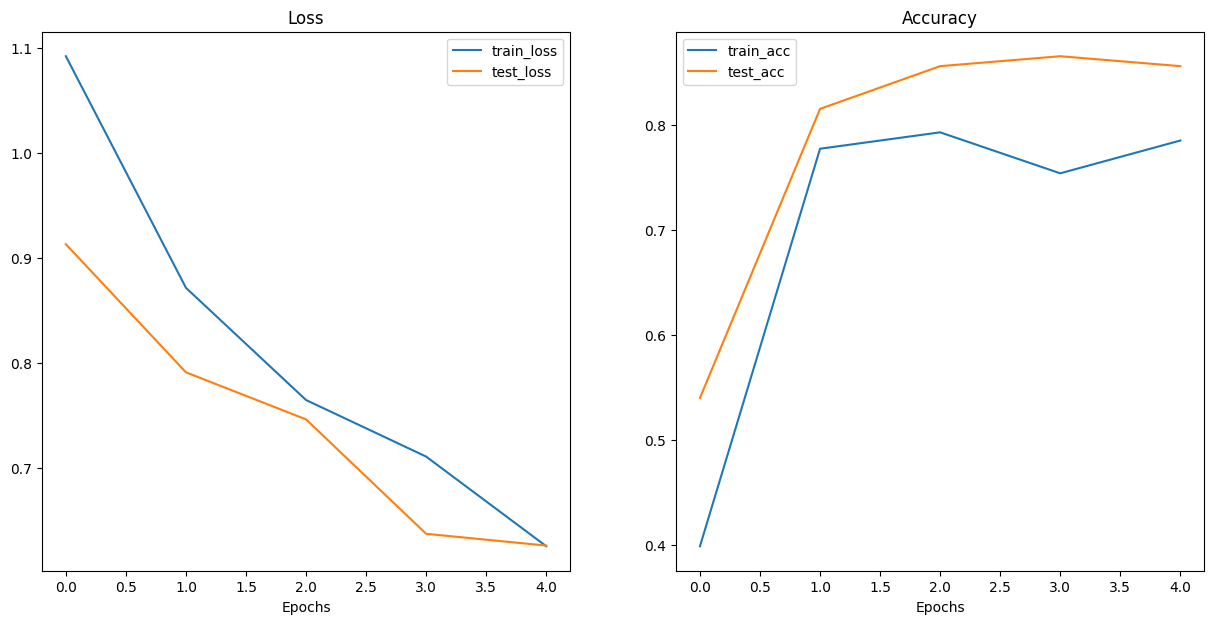

In [24]:
plot_loss_curves(results)

## 6.0 Make predictions on images from the test set

Let's adhere to the data explorer's motto of "visualize, visualize, visualize!"

And make somequalitative predictiondson our test set.

Some things to keep in mind when making predictions/inference on test data/custom data.

We have to make sure that our test/custom data is:
* Same shape - images need to be the same shape as model was trained on
* Same datatype - custom data should be in the same data type
* Same device - custom data/test data should be on the same device as the model
* Same transform - if you've transformed your custom data, ideally you will transform the test data and custom data the same.

To do all of this automatically, let's create a function called `pres_and_plot_image()`:

The function will be similar to the one in section 4

1. Take in a trained model, a list of class names, a filepath to a target image, an image size, a transform and a target device

2. open the image with `PIL.Image.Open()`
3. Create a transform if one doesnt exist
4. Make sure the model is on the target device
5. Turn the model to `model.eval()` mode to make sure it's ready for inferenc (this will turn off things like `nn.Dropout()`)
6. Transform the target image and make sure its dimensionality is suited for the model (this mainly relates to the batch size)
7. Make a prediction on the image by passing to the model
8. Convert model's output logits to the prediction probabilities using `torch.softmax()`
9. Convert model's prediction probs to pred labels using argmax
10. Plot the image and set the title to the pred label from 9 and the pred prob of step 8


In [25]:
from PIL import Image

def pred_and_plot_images(cust_img_path, model, class_names, img_size, transform=None, device=device):
    cust_img = Image.open(cust_img_path)

    if transforms:
        image_transform = transform
    else:
        image_transform = transforms.Compose([
                                        transforms.Resize(size=img_size),
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                             std=[0.229, 0.224, 0.225])])

    img = image_transform(cust_img).unsqueeze(0).to(device)
    model = model.to(device)
    model.eval()
    with torch.inference_mode():
        y_logit = model(img)
    y_pred_prob = torch.softmax(y_logit, dim=1)
    y_label = torch.argmax(y_pred_prob, dim=1)

    plt.figure()
    plt.imshow(cust_img)
    plt.title(f'Pred: {class_names[y_label]} | Probability: {y_pred_prob.max():.3f}')
    plt.axis(False)




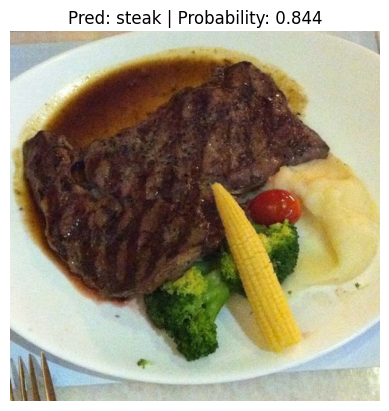

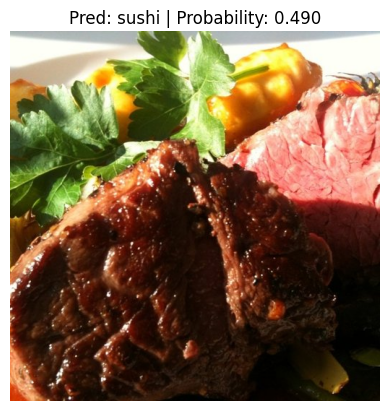

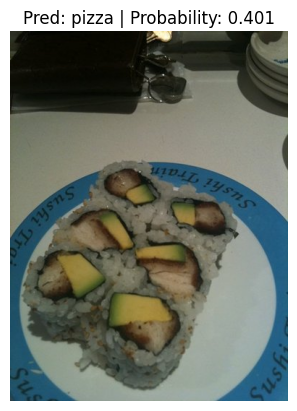

In [26]:
import random
random.seed(42)

num_imgs_to_plot = 3
img_path_list = list(Path(test_dir).glob('*/*.jpg'))
samples = random.sample(img_path_list, k=num_imgs_to_plot)

for sample in samples:
    pred_and_plot_images(cust_img_path=sample,
                         model=model,
                         class_names=class_names,
                         img_size=(224, 224),
                         transform=auto_transforms)

### 6.1 Making predictions on a custom image

Let's make a prediction on the data dad image

In [28]:
str(train_dir.parent)

'data/pizza_steak_sushi'

In [29]:
import requests

cust_img_path = train_dir.parent / "04-pizza-dad.jpg"

# download it if it doesn't exist
if not cust_img_path.is_file():
    with open(cust_img_path, 'wb') as f:
        r = requests.get('https://github.com/mrdbourke/pytorch-deep-learning/raw/main/images/04-pizza-dad.jpeg')
        f.write(r.content)

else:
    print(f"{cust_img_path} already exists, skipping download...")

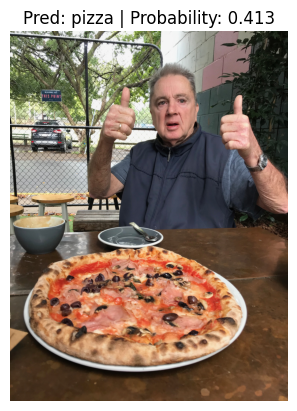

In [30]:
pred_and_plot_images(cust_img_path=cust_img_path,
                         model=model,
                         class_names=class_names,
                         img_size=(224, 224),
                         transform=auto_transforms)

## Exercises: https://colab.research.google.com/drive/1wj1nQ0grr4lC5KbKK_KyPzlHIkfmULiz?hl=en